In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [21]:
df = pd.read_csv("E:/sem5/apl302product/computational_project/reduced_data.csv")

In [22]:
X = df.values

# Min-Max Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# Hyperparameters
latent_dim = 64  # Increased latent dimension
hidden_dim = 256  # Increased hidden dimension
lr = 0.0001  # Lower learning rate
num_epochs = 5000
batch_size = 64

# Convert data to torch tensors
real_data = torch.tensor(X, dtype=torch.float32).to(device)


In [24]:
# Define Generator for Tabular Data
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.model(z)

In [25]:
# Define Discriminator for Tabular Data
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [26]:
# Initialize generator and discriminator
generator = Generator(latent_dim, X.shape[1]).to(device)
discriminator = Discriminator(X.shape[1]).to(device)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [27]:
# Training loop
for epoch in range(num_epochs):
    # Sample real data batch
    idx = torch.randint(0, len(real_data), (batch_size,))
    real_samples = real_data[idx]
    valid = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing for real data
    fake = torch.zeros(batch_size, 1).to(device)

    # Train Discriminator
    optimizer_D.zero_grad()
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_samples = generator(z)
    real_loss = adversarial_loss(discriminator(real_samples), valid)
    fake_loss = adversarial_loss(discriminator(fake_samples.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    gen_loss = adversarial_loss(discriminator(fake_samples), valid)
    gen_loss.backward()
    optimizer_G.step()

    # Display progress
    if epoch % 500 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {gen_loss.item():.4f}")

# Generate synthetic data after training
num_samples = 10000
z = torch.randn(num_samples, latent_dim).to(device)
generated_data = generator(z).detach().cpu().numpy()
generated_data = scaler.inverse_transform(generated_data)  # Reverse Min-Max scaling

# Save generated data to CSV
generated_df = pd.DataFrame(generated_data, columns=df.columns)
generated_df.to_csv('E:/sem5/apl302product/computational_project/generated_data2.csv', index=False)

print("New data generated and saved as 'generated_data2.csv'")

Epoch [0/5000] | D Loss: 0.7007 | G Loss: 0.6659
Epoch [500/5000] | D Loss: 0.6660 | G Loss: 0.8026
Epoch [1000/5000] | D Loss: 0.6900 | G Loss: 0.8095
Epoch [1500/5000] | D Loss: 0.7099 | G Loss: 0.7732
Epoch [2000/5000] | D Loss: 0.6873 | G Loss: 0.7801
Epoch [2500/5000] | D Loss: 0.6676 | G Loss: 0.8041
Epoch [3000/5000] | D Loss: 0.6886 | G Loss: 0.7987
Epoch [3500/5000] | D Loss: 0.6768 | G Loss: 0.7975
Epoch [4000/5000] | D Loss: 0.6674 | G Loss: 0.8222
Epoch [4500/5000] | D Loss: 0.6661 | G Loss: 0.8134
New data generated and saved as 'generated_data2.csv'


In [28]:
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance, ks_2samp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Load real and generated data
real_data = pd.read_csv("E:/sem5/apl302product/computational_project/reduced_data.csv").values
generated_data = pd.read_csv('E:/sem5/apl302product/computational_project/generated_data2.csv').values

In [30]:
# 1. Statistical Similarity: Compare distributions with Wasserstein Distance and Kolmogorov-Smirnov Test
distances = [wasserstein_distance(real_data[:, i], generated_data[:, i]) for i in range(real_data.shape[1])]
mean_wasserstein_distance = np.mean(distances)
print(f"Mean Wasserstein Distance (Lower is better): {mean_wasserstein_distance:.4f}")


Mean Wasserstein Distance (Lower is better): 0.9550


In [31]:
ks_statistics = [ks_2samp(real_data[:, i], generated_data[:, i]).statistic for i in range(real_data.shape[1])]
mean_ks_statistic = np.mean(ks_statistics)
print(f"Mean KS Statistic (Lower is better): {mean_ks_statistic:.4f}")

Mean KS Statistic (Lower is better): 0.1246


In [32]:
# For example, a binary target column
np.random.seed(0)
real_target = np.random.randint(0, 2, size=len(real_data))
generated_target = np.random.randint(0, 2, size=len(generated_data))

X_train, y_train = generated_data, generated_target
X_test, y_test = real_data, real_target

# Train classifier on synthetic data and evaluate on real data
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy trained on synthetic data and tested on real data: {model_accuracy:.4f}")


Model accuracy trained on synthetic data and tested on real data: 0.4993


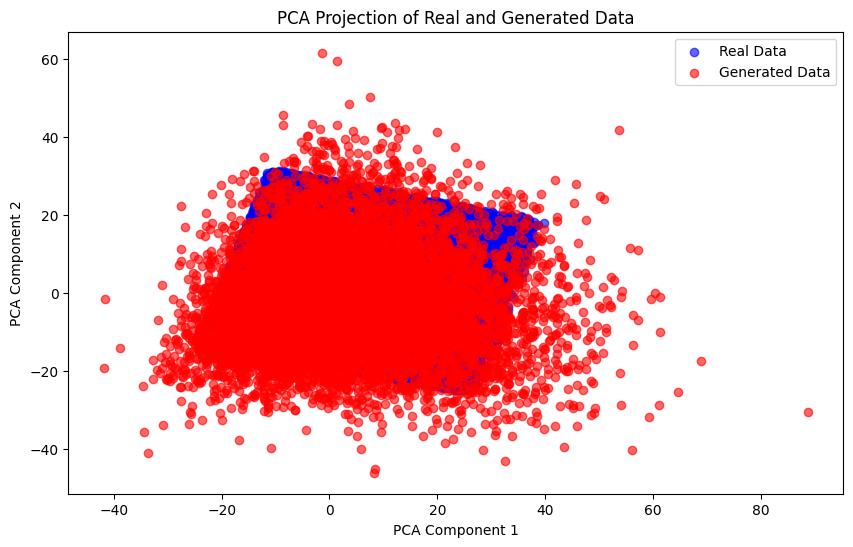

In [33]:
# 3. Dimensionality Reduction Visualization: PCA
pca = PCA(n_components=2)
real_data_pca = pca.fit_transform(real_data)
generated_data_pca = pca.transform(generated_data)

plt.figure(figsize=(10, 6))
plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], label="Real Data", alpha=0.6, c='blue')
plt.scatter(generated_data_pca[:, 0], generated_data_pca[:, 1], label="Generated Data", alpha=0.6, c='red')
plt.title("PCA Projection of Real and Generated Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [34]:
combined_data = np.vstack((real_data, generated_data))
labels = np.array([0] * len(real_data) + [1] * len(generated_data))  # Label real as 0, generated as 1
silhouette_avg = silhouette_score(combined_data, labels)
print(f"Silhouette Score for real vs generated data (Closer to 1 is better): {silhouette_avg:.4f}")

# Summary of Results
print("\nQuality Metrics Summary:")
print(f"Mean Wasserstein Distance: {mean_wasserstein_distance:.4f}")
print(f"Mean KS Statistic: {mean_ks_statistic:.4f}")
print(f"Model Accuracy: {model_accuracy:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score for real vs generated data (Closer to 1 is better): 0.0564

Quality Metrics Summary:
Mean Wasserstein Distance: 0.9550
Mean KS Statistic: 0.1246
Model Accuracy: 0.4993
Silhouette Score: 0.0564
